In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Texas
state_ab = "tx"

## Data
1. Download all the data in directory "tx_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_2021/PLANC2193.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/PLANS2168.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_2021/PLANH2316.shp".format(data_folder, state_ab)

In [6]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    
    # check maup doctor again to see if smart repair works
    if maup.doctor(df) == True:
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        df = df.to_crs('EPSG:4269')
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs('EPSG:4269')
    dist_df = dist_df.to_crs('EPSG:4269')
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col):
    df = df.to_crs('EPSG:4269')
    vest = vest.to_crs('EPSG:4269')
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = "EPSG:4269")
    # check if population agrees
    check_population(population, df)
    
    return df

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [16]:
maup.doctor(population_df)

100%|█████████████████████████████████| 668757/668757 [05:06<00:00, 2183.76it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

## Read the vest 20 data

Now using it as a "base pricinct"

In [21]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [23]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████████████████████████████████| 9014/9014 [00:10<00:00, 836.40it/s]


There are 4 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 9073/9073 [00:03<00:00, 2835.87it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 4/4 [00:06<00:00,  1.64s/it]
Gaps to fill: 0it [00:00, ?it/s]
100%|█████████████████████████████████████| 9014/9014 [00:08<00:00, 1038.02it/s]


In [24]:
vest20.columns

Index(['CNTY', 'COLOR', 'PREC', 'PCTKEY', 'CNTYKEY', 'G20VR', 'G20SSVR',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'G20PREOWRI',
       'G20USSRCOR', 'G20USSDHEG', 'G20USSLMCK', 'G20USSGCOL', 'G20RRCRWRI',
       'G20RRCDCAS', 'G20RRCLSTE', 'G20RRCGGRU', 'G20SSCRHEC', 'G20SSCDMEA',
       'G20SSCLASH', 'G20SSCRBLA', 'G20SSCDCHE', 'G20SSCRBOY', 'G20SSCDWIL',
       'G20SSCLSTR', 'G20SSCRBUS', 'G20SSCDTRI', 'G20SSCLOXF', 'G20SCCRRIC',
       'G20SCCDFRI', 'G20SCCRYEA', 'G20SCCDCLI', 'G20SCCRNEW', 'G20SCCDBIR',
       'geometry'],
      dtype='object')

## Fields
G20VR - Voter registration
G20SSVR - Spanish surname voter registration

In [26]:
start_col = 7
vest_base_data = vest20
year = '20'

In [27]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [28]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 9014/9014 [01:22<00:00, 109.34it/s]


In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [31]:
election_df.columns

Index(['CNTY', 'CNTYKEY', 'COLOR', 'G20SSVR', 'G20VR', 'PCTKEY', 'PRE20D',
       'PRE20O', 'PRE20R', 'PREC', 'RRC20D', 'RRC20O', 'RRC20R', 'SCC20D',
       'SCC20R', 'SSC20D', 'SSC20O', 'SSC20R', 'USS20D', 'USS20O', 'USS20R',
       'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [33]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,29145505,29145505.0,True
HISP,HISP,11441717,11441717.0,True
NH_WHITE,NH_WHITE,11584597,11584597.0,True
NH_BLACK,NH_BLACK,3444712,3444712.0,True
NH_AMIN,NH_AMIN,85425,85425.0,True
NH_ASIAN,NH_ASIAN,1561518,1561518.0,True
NH_NHPI,NH_NHPI,27857,27857.0,True
NH_OTHER,NH_OTHER,113584,113584.0,True
NH_2MORE,NH_2MORE,886095,886095.0,True
H_WHITE,H_WHITE,3024768,3024768.0,True


## Add more vest data

In [35]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [36]:
vest18.columns

Index(['CNTY', 'COLOR', 'PREC', 'PCTKEY', 'CNTYKEY', 'G18VR', 'G18SSVR',
       'G18USSRCRU', 'G18USSDORO', 'G18USSLDIK', 'G18GOVRABB', 'G18GOVDVAL',
       'G18GOVLTIP', 'G18LTGRPAT', 'G18LTGDCOL', 'G18LTGLMCK', 'G18ATGRPAX',
       'G18ATGDNEL', 'G18ATGLHAR', 'G18COMRHEG', 'G18COMDCHE', 'G18COMLSAN',
       'G18LANRBUS', 'G18LANDSUA', 'G18LANLPIN', 'G18AGRRMIL', 'G18AGRDOLS',
       'G18AGRLCAR', 'G18RRCRCRA', 'G18RRCDMCA', 'G18RRCLWRI', 'G18SSCRBLA',
       'G18SSCDKIR', 'G18SSCRDEV', 'G18SSCDSAN', 'G18SSCRBRO', 'G18SSCDCHE',
       'G18SCCRKEL', 'G18SCCDJAC', 'G18SCCLSTR', 'G18SCCRHER', 'G18SCCDFRA',
       'G18SCCRSLA', 'G18SCCLASH', 'geometry'],
      dtype='object')

In [37]:
vest16.columns

Index(['CNTY', 'COLOR', 'PREC', 'PCTKEY', 'CNTYKEY', 'G16VR', 'G16SSVR',
       'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREOWRI',
       'G16RRCRCHR', 'G16RRCDYAR', 'G16RRCLMIL', 'G16RRCGSAL', 'G16SSCRLEH',
       'G16SSCDWES', 'G16SSCLGLA', 'G16SSCGMUN', 'G16SSCRGRE', 'G16SSCDGAR',
       'G16SSCLOXF', 'G16SSCGWAT', 'G16SSCRGUZ', 'G16SSCDROB', 'G16SSCLFUL',
       'G16SSCGCHI', 'G16SCCRKEE', 'G16SCCDMEY', 'G16SCCLASH', 'G16SCCGREP',
       'G16SCCRWAL', 'G16SCCDJOH', 'G16SCCLSTR', 'G16SCCGSAN', 'G16SCCRKEA',
       'G16SCCDBUR', 'G16SCCLBEN', 'geometry'],
      dtype='object')

In [38]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████████████████████████████████| 8936/8936 [00:13<00:00, 645.56it/s]


There are 2 overlaps.
There are 2 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8989/8989 [00:02<00:00, 3524.10it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 2/2 [00:03<00:00,  1.56s/it]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████| 9014/9014 [01:25<00:00, 105.41it/s]


population agrees


In [39]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'BVAP', 'CNTY', 'CNTYKEY', 'COLOR',
       'COM18D', 'COM18O', 'COM18R', 'G20SSVR', 'G20VR', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'LAN18D', 'LAN18O', 'LAN18R', 'LTG18D',
       'LTG18O', 'LTG18R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN',
       'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PCTKEY',
       'PRE20D', 'PRE20O', 'PRE20R', 'PREC', 'RRC18D', 'RRC18O', 'RRC18R',
       'RRC20D', 'RRC20O', 'RRC20R', 'SCC18D', 'SCC18O', 'SCC18R', 'SCC20D',
       'SCC20R', 'SSC18D', 'SSC18R', 'SSC20D', 'SSC20O', 'SSC20R', 'TOTPOP',
       'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20O', 'USS20R', 'VAP',
       'WVAP', 'geometry'],
      dtype='object')

In [40]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████████████████████████████████| 8832/8832 [00:10<00:00, 881.42it/s]


There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -4 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8883/8883 [00:02<00:00, 3220.29it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████| 9014/9014 [01:22<00:00, 109.37it/s]


population agrees


##  Add the district data

In [42]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [43]:
send.head()

,District,geometry
0,1,"POLYGON ((1473551.679 1085915.992, 1473549.573..."
1,2,"POLYGON ((1331022.808 1074894.416, 1331018.925..."
2,3,"POLYGON ((1483706.915 869096.111, 1483705.780 ..."
3,4,"POLYGON ((1507538.844 810137.108, 1505702.017 ..."
4,5,"POLYGON ((1259037.401 850451.740, 1258813.045 ..."


In [44]:
send = send.to_crs("EPSG:4269")
election_df = add_district(send, "SEND", election_df, "District")

100%|███████████████████████████████████████████| 31/31 [00:05<00:00,  5.73it/s]


In [45]:
hdist.head()

,District,geometry
0,1,"POLYGON ((1494406.980 1201348.426, 1494404.818..."
1,2,"POLYGON ((1368626.668 1138307.981, 1368617.076..."
2,3,"POLYGON ((1455820.856 884283.339, 1455817.544 ..."
3,4,"POLYGON ((1366839.633 1106996.402, 1366810.030..."
4,5,"POLYGON ((1470631.844 1131634.573, 1470630.166..."


In [46]:
hdist = hdist.to_crs("EPSG:4269")
election_df = add_district(hdist, "HDIST", election_df, "District")

100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.84it/s]


In [47]:
cong_df = gpd.read_file(cd_data)
if maup.doctor(cong_df) != True:
    cong_df = do_smart_repair(cong_df)

100%|███████████████████████████████████████████| 38/38 [00:00<00:00, 57.03it/s]


In [48]:
cong_df.head()

,District,geometry
0,1,"POLYGON ((1558608.508 1007368.924, 1558424.339..."
1,2,"POLYGON ((1470535.622 854436.946, 1470480.616 ..."
2,3,"POLYGON ((1345931.776 1197371.115, 1345909.051..."
3,4,"POLYGON ((1406092.294 1178910.749, 1406000.068..."
4,5,"POLYGON ((1372124.540 1099497.361, 1372124.382..."


In [49]:
cong_df = cong_df.to_crs("EPSG:4269")
election_df = add_district(cong_df, "CD", election_df, "District")

100%|███████████████████████████████████████████| 38/38 [00:04<00:00,  8.64it/s]


In [50]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'BVAP', 'CNTY', 'CNTYKEY', 'COLOR',
       'COM18D', 'COM18O', 'COM18R', 'G20SSVR', 'G20VR', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'LAN18D', 'LAN18O', 'LAN18R', 'LTG18D',
       'LTG18O', 'LTG18R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN',
       'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PCTKEY',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'PREC',
       'RRC16D', 'RRC16O', 'RRC16R', 'RRC18D', 'RRC18O', 'RRC18R', 'RRC20D',
       'RRC20O', 'RRC20R', 'SCC16D', 'SCC16O', 'SCC16R', 'SCC18D', 'SCC18O',
       'SCC18R', 'SCC20D', 'SCC20R', 'SSC16D', 'SSC16O', 'SSC16R', 'SSC18D',
       'SSC18R', 'SSC20D', 'SSC20O', 'SSC20R', 'TOTPOP', 'USS18D', 'USS18O',
       'USS18R', 'USS20D', 'USS20O', 'USS20R', 'VAP', 'WVAP', 'geometry',
       'SEND', 'H

### Put the base precinct year after the precinct information column

In [52]:
'CNTY', 'COLOR', 'PREC', 'PCTKEY', 'CNTYKEY', 'G20VR', 'G20SSVR'
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'CNTY':'CNTY'+year,
        'COLOR':'COLOR'+year,
        'PREC':'PREC'+year,
        'PCTKEY':'PCTKEY'+year,
        'CNTYKEY':'CNTYKEY'+year,
        'G20VR':'G20VR'+year,
        'G20SSVR':'G20SSVR'+year}
election_df.rename(columns=base_columns, inplace = True)

In [53]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'BVAP', 'CNTY20', 'CNTYKEY20', 'COLOR20',
       'COM18D', 'COM18O', 'COM18R', 'G20SSVR20', 'G20VR20', 'GOV18D',
       'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN',
       'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'LAN18D', 'LAN18O', 'LAN18R',
       'LTG18D', 'LTG18O', 'LTG18R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PCTKEY20', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PREC20', 'RRC16D', 'RRC16O', 'RRC16R', 'RRC18D', 'RRC18O', 'RRC18R',
       'RRC20D', 'RRC20O', 'RRC20R', 'SCC16D', 'SCC16O', 'SCC16R', 'SCC18D',
       'SCC18O', 'SCC18R', 'SCC20D', 'SCC20R', 'SSC16D', 'SSC16O', 'SSC16R',
       'SSC18D', 'SSC18R', 'SSC20D', 'SSC20O', 'SSC20R', 'TOTPOP', 'USS18D',
       'USS18O', 'USS18R', 'USS20D', 'USS20O', 'USS20R', 'VAP', 'WVAP',
       'geometr

In [54]:
maup.doctor(election_df)

100%|██████████████████████████████████████| 9014/9014 [00:10<00:00, 867.81it/s]


True

In [55]:
# reorder the columns
fixed_columns = [
    'CNTY'+year,
    'COLOR'+year,
    'PREC'+year,
    'PCTKEY'+year,
    'CNTYKEY'+year,
    'G20VR'+year,
    'G20SSVR'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [56]:
election_df.columns

Index(['CNTY20', 'COLOR20', 'PREC20', 'PCTKEY20', 'CNTYKEY20', 'G20VR20',
       'G20SSVR20', 'CD', 'SEND', 'HDIST', 'TOTPOP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'HISP',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R',
       'ATG18D', 'ATG18O', 'ATG18R', 'COM18D', 'COM18O', 'COM18R', 'GOV18D',
       'GOV18O', 'GOV18R', 'LAN18D', 'LAN18O', 'LAN18R', 'LTG18D', 'LTG18O',
       'LTG18R', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'RRC16D', 'RRC16O', 'RRC16R', 'RRC18D', 'RRC18O', 'RRC18R', 'RRC20D',
       'RRC20O', 'RRC20R', 'SCC16D', 'SCC16O', 'SCC16R', 'SCC18D', 'SCC18O',
       'SCC18R', 'SCC20D', 'SCC20R', 'SSC16D', 'SSC16O', 'SSC16R', 'SSC18D',
       'SSC18R', 'SSC20D', 'SSC20O', 'SSC20R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS2

In [57]:
import os

# store the result in directory "tx"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

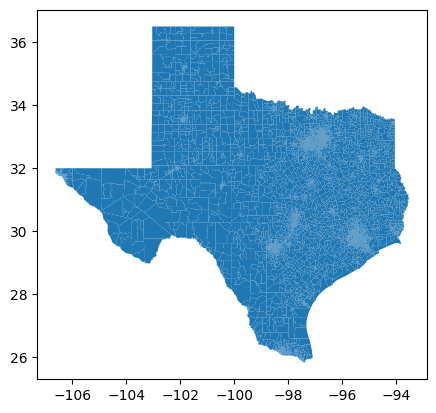

In [58]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()